In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback =  20    #int (input('days to search financial data:'))

In [3]:
riskfree = .0019

In [4]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [5]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-07-05 14-52-03'

In [6]:
path = os.getcwd() 
reportDir = os.path.join(path, "Markowitz portflio output " + timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/Markowitz portflio output 2020-07-05 14-52-03'

In [7]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [8]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [9]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [10]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [11]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [12]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [13]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 7.81 s, sys: 683 ms, total: 8.49 s
Wall time: 1min 6s


In [14]:
df = df.loc[df['Date'].notnull()]

In [15]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [16]:
df_Flat = df

# Prepare data frame to display volatility and to be normalized

In [17]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)

In [94]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-16,0.026157,0.031514,0.002119,0.022812,0.025413,0.003008,0.013100,0.031750,0.008686,0.016419,...,0.023202,0.017941,0.001797,0.014337,0.005824,0.013620,0.015782,0.010929,0.013208,0.022237
2020-06-17,-0.001393,-0.003337,0.012843,0.003906,0.004411,-0.030809,-0.011874,-0.003975,-0.003064,0.009783,...,-0.001366,0.001169,0.010901,-0.021324,0.003519,-0.004755,0.000000,-0.038239,-0.005195,-0.033115
2020-06-18,0.000398,0.005105,-0.006844,-0.011124,0.016716,0.005869,0.008134,0.019067,-0.024427,0.004910,...,-0.003835,-0.001871,0.005499,0.001557,0.001807,0.004228,-0.004041,0.003636,-0.008776,0.006200
2020-06-19,-0.005731,0.004976,0.004421,-0.006824,0.017797,-0.020536,-0.000203,0.035738,0.030583,0.007893,...,-0.000824,-0.017715,0.001765,0.007748,-0.008858,-0.012915,0.049947,0.001813,0.015641,-0.020237
2020-06-22,0.025827,0.005774,-0.003757,0.005196,0.024532,-0.000629,-0.016030,-0.019075,-0.003772,0.014404,...,0.004898,0.002083,-0.008105,-0.016864,0.014258,-0.008943,-0.020374,-0.009099,0.015154,0.009524
2020-06-23,0.021120,0.000411,0.010571,0.023416,0.004345,0.008145,-0.005159,0.006639,-0.000378,0.018470,...,0.016705,0.006873,0.034117,0.009893,0.015321,-0.013020,-0.009994,-0.004397,-0.005026,0.006014
2020-06-24,-0.017810,-0.022552,-0.044800,-0.027174,-0.020339,-0.056149,-0.039138,-0.013839,-0.039799,-0.010915,...,-0.028701,-0.022753,-0.010086,-0.045854,-0.033698,-0.018555,-0.039062,-0.041618,-0.006380,-0.048255
2020-06-25,0.013188,0.019258,0.026228,0.073896,0.012134,0.031192,0.030514,0.011120,0.000708,0.007353,...,0.024053,0.008840,0.009272,0.031503,0.013337,0.006469,0.020912,0.046746,-0.004917,0.014944


# pick tickers to use for portfolio
( highest growth rates)

In [19]:
tickers_bestPerformed = logChange.describe().transpose().sort_values(by='mean', ascending=False).head(5)
symbols = tickers_bestPerformed.index.tolist()

### ---------------------------------------------------------------------------------------------------------------------------------

In [95]:
#randomly picked tickers
import random
symbols = random.choices(logChange.columns, k=5)

### ------------------------------------------------------------------------------------

In [96]:
logChange = logChange[symbols]
logChange

Symbol,AAPL,CL,GE,AMZN,EMR
Date,,,,,
2020-06-15,NaN,NaN,NaN,NaN,NaN
2020-06-16,0.026157,0.008742,0.031274,0.016419,0.018930
2020-06-17,-0.001393,0.003801,-0.031274,0.009783,-0.013804
2020-06-18,0.000398,-0.002713,0.005510,0.004910,-0.019359
2020-06-19,-0.005731,-0.003402,-0.018019,0.007893,0.009565
2020-06-22,0.025827,-0.003550,-0.015504,0.014404,-0.008751
2020-06-23,0.021120,-0.002465,-0.005698,0.018470,0.006166
2020-06-24,-0.017810,-0.012280,-0.069503,-0.010915,-0.036068
2020-06-25,0.013188,0.008433,0.022711,0.007353,0.012002


### expected return of each ticker picked

In [97]:
logChange.mean()*252   #252 business days per year in general

Symbol
AAPL    1.158322
CL      0.103441
GE     -1.158457
AMZN    2.256606
EMR    -0.193973
dtype: float64

##### covariance across tickers

In [98]:
logChange.cov()*252

Symbol,AAPL,CL,GE,AMZN,EMR
Symbol,,,,,
AAPL,0.075904,0.026819,0.091706,0.034679,0.044777
CL,0.026819,0.018919,0.053624,0.014575,0.027772
GE,0.091706,0.053624,0.235992,0.027288,0.111919
AMZN,0.034679,0.014575,0.027288,0.069794,0.011494
EMR,0.044777,0.027772,0.111919,0.011494,0.075402


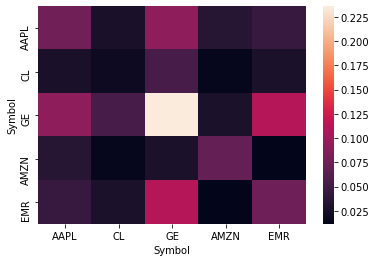

In [99]:
sns.heatmap(logChange.cov()*252)

# Portfolio with randomly assinged weights

#### get random portofolio weights to run simulations

In [100]:
np.random.seed(0)
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.19356424, 0.25224431, 0.21259213, 0.19217803, 0.14942128])

In [101]:
#expeced annual return of portfolio
np.sum(logChange.mean()*weights)*252

0.40870972413411794

In [102]:
#expected annual variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.05356913099310638

In [103]:
#expected annual standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.23145006155347286

# Simulation of portfolios with random weights

In [104]:
prets = []  #stores list of portfolio returns
pvols = []  #stores list of portolfio volatilities

for p in range (5000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

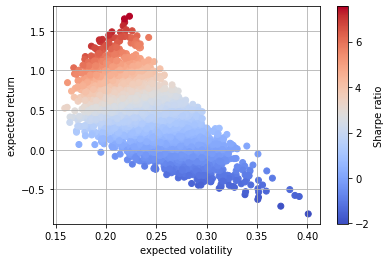

In [105]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm') # mpl.cm.jet)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [106]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
    
    Returns
    =======
    pret : float  (portfolio return)
    pvol : float   (portfoliio volatility)
    pret / pvol : float      #sharp ratio (beta)

    '''
    riskfree = .0019   #risk free rate .19% (1 Year Treasury Rate is at 0.19%)
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, ((pret-riskfree )/ pvol)])

### Sharp ratio optimization

In [107]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [108]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [109]:
#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
statistics(w)

array([0.43318785, 0.23369364, 1.84552672])

In [110]:
bnds = tuple((0, 1) for x in range(len(symbols)))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [111]:
#set initial point
len(symbols)* [1./len(symbols),]

[0.2, 0.2, 0.2, 0.2, 0.2]

#### Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

#### scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

In [112]:
%%time

opts = sco.minimize(min_func_sharpe, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)


CPU times: user 38.1 ms, sys: 4.36 ms, total: 42.5 ms
Wall time: 38.5 ms


In [113]:
opts

     fun: -8.535861846176992
     jac: array([-8.29958916e-03,  1.44947791e+00,  7.97657275e+00, -7.23934174e-03,
        2.25093913e+00])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.87301046e-02, 2.42763708e-14, 0.00000000e+00, 9.81269895e-01,
       2.26715348e-14])

In [114]:
a=opts['x'].round(3)   #opt weights
#print("exp return :" + str( np.sum(logChange.mean()*a)*252  )  ).round(3)   #1yr exp return of portfolio with opt weights 
print("exp return :" + str( statistics(opts['x'].round(3))[0].round(3) ) )
print("exp volatility :" + str( statistics(opts['x'].round(3))[1].round(3) )  )
print("exp sharp ratio :" + str( statistics(opts['x'].round(3))[2].round(3) )  )

exp return :2.236
exp volatility :0.262
exp sharp ratio :8.536


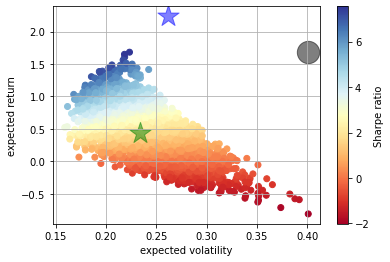

In [115]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
plt.scatter(statistics(w)[1], statistics(w)[0], marker="*", s= 500, alpha=0.5, color='g')


# add a red dot for maximum vol & maximum return
plt.scatter(pvols.max(), prets.max(), c='black', s=500, alpha=0.5, edgecolors='black')



plt.show()

### Volatility Optimization

In [116]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [117]:
optv = sco.minimize(min_func_variance,  len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [118]:
optv

     fun: 0.018602527069613215
     jac: array([0.05478454, 0.03720505, 0.10340649, 0.03720505, 0.05316997])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([4.37486818e-17, 9.27069214e-01, 0.00000000e+00, 7.29307858e-02,
       5.23135964e-17])

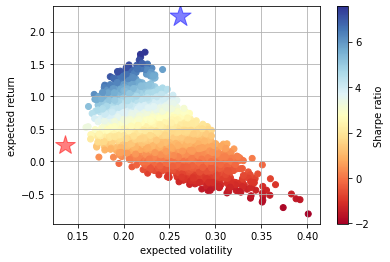

In [119]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
           
    
plt.show()

# Efficient Frontier

## Minimum variance frontier

In [120]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [121]:
def min_func_port(weights):
    return statistics(weights)[1]

In [122]:
prets.min(), prets.max(), pt_opts[0]

(-0.8083096148050429, 1.6824444770000317, 2.236)

In [123]:
%%time


trets = np.linspace( prets.min() , max(prets.max(), pt_opts[0].max()), 50)
tvols = []
for tret in trets:       #getting weight where minimum volatility occurs for each returned value
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 2.85 s, sys: 7.5 ms, total: 2.86 s
Wall time: 2.86 s


In [167]:
tvols

array([0.38230295, 0.36412975, 0.34603655, 0.32803656, 0.31014603,
       0.29238505, 0.27477874, 0.25735885, 0.24016595, 0.22325247,
       0.20668704, 0.19056044, 0.17499403, 0.16015125, 0.14625257,
       0.13727031, 0.1366538 , 0.13639855, 0.1365066 , 0.13697708,
       0.13780628, 0.13898778, 0.1405127 , 0.14236999, 0.14454686,
       0.1470291 , 0.14980153, 0.15284837, 0.15615356, 0.15970104,
       0.16347506, 0.16746029, 0.17164203, 0.17600626, 0.18053976,
       0.1852301 , 0.19005508, 0.19498704, 0.20001778, 0.20514022,
       0.21034726, 0.215633  , 0.22099178, 0.22641842, 0.23190816,
       0.2374566 , 0.24305975, 0.24871411, 0.25482667, 0.26173104])

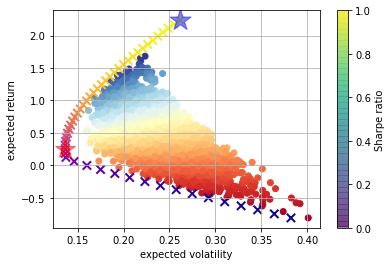

In [125]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
    
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')

 
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Efficient frontier

In [126]:
import scipy.interpolate as sci

In [127]:
np.argmin(tvols) #find index of minimum value of volatility 


17

In [128]:
ind = np.argmin(tvols)
evols = tvols[ind:]    #include array only up to the index of minimum volatility
erets = trets[ind:]


In [129]:
tck = sci.splrep(evols, erets)

In [130]:
def f(x):
    ''' efficient frontier (spline) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' efficient frontier (first derivative)'''
    return sci.splev(x, tck, der=1)
f(0)

array(-2228273.59255111)

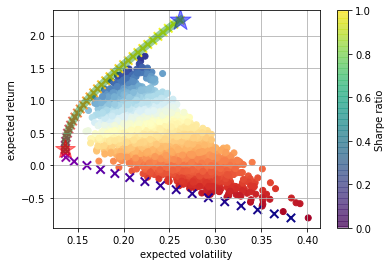

In [131]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  

# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
 

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Capital market line (CML)

In [132]:
riskfree

0.0019

In [168]:
def equations(p, rf=riskfree):
    eq1 = rf-p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [169]:
opt = sco.fsolve(equations,[0.01, 1.0, 0.1])
opt

array([1.90000000e-03, 2.70331345e+00, 1.36889363e-01])

In [162]:
np.round(equations(opt), 8)

array([ 0.00e+00, -1.59e-06,  1.23e-06])

In [163]:
erets, f(evols)

(array([0.24787944, 0.3100082 , 0.37213697, 0.43426574, 0.49639451,
        0.55852327, 0.62065204, 0.68278081, 0.74490958, 0.80703834,
        0.86916711, 0.93129588, 0.99342465, 1.05555341, 1.11768218,
        1.17981095, 1.24193972, 1.30406849, 1.36619725, 1.42832602,
        1.49045479, 1.55258356, 1.61471232, 1.67684109, 1.73896986,
        1.80109863, 1.86322739, 1.92535616, 1.98748493, 2.0496137 ,
        2.11174246, 2.17387123, 2.236     ]),
 array([0.24787944, 0.3100082 , 0.37213697, 0.43426574, 0.49639451,
        0.55852327, 0.62065204, 0.68278081, 0.74490958, 0.80703834,
        0.86916711, 0.93129588, 0.99342465, 1.05555341, 1.11768218,
        1.17981095, 1.24193972, 1.30406849, 1.36619725, 1.42832602,
        1.49045479, 1.55258356, 1.61471232, 1.67684109, 1.73896986,
        1.80109863, 1.86322739, 1.92535616, 1.98748493, 2.0496137 ,
        2.11174246, 2.17387123, 2.236     ]))

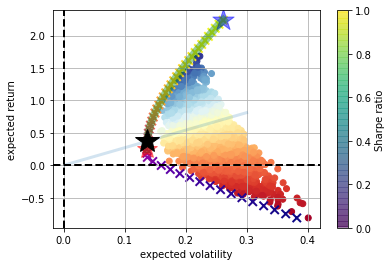

In [164]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  #plt.plot(evols, erets, 'g', lw=2, alpha=.8)    


# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

    
# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')

 
#Capital market line
cx = np.linspace(riskfree, 0.3 )   # (0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=3, alpha=0.2, ) 
    
    
#optimal portfolio  
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0, color='black') 


plt.grid(True)
plt.axhline(0.0, color='k', ls='--', lw=2.0)
plt.axvline(0.0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

#### Optimal portfolio weights

In [165]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.   , 0.875, 0.   , 0.125, 0.   ])

#### return, volatility, and sharp ratio expected with the optimal weights

In [166]:
statistics(res['x'].round(3))

array([0.37258681, 0.1369818 , 2.7061027 ])

In [144]:
symbols

['AAPL', 'CL', 'GE', 'AMZN', 'EMR']

In [145]:
summary_output = pd.DataFrame({'Symbol': symbols})
summary_output['Weight'] = res['x'].round(3)

In [146]:
summary_output = pd.merge(summary_output , (logChange.mean()*252).reset_index(name='temp'))

In [147]:
summary_output['Exp return'] = summary_output['Weight']*summary_output['temp']

In [148]:
summary_output = summary_output.pivot_table(index='Symbol', values=['Weight', 'Exp return']  , aggfunc=np.sum, margins=True)



In [149]:
summary_output

,Exp return,Weight
Symbol,,
AAPL,0.000000,0.000
AMZN,0.282076,0.125
CL,0.090511,0.875
EMR,0.000000,0.000
GE,0.000000,0.000
All,0.372587,1.000


In [ ]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [ ]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [ ]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [ ]:
story = []

In [ ]:
story.append(Paragraph("Portfolio", getSampleStyleSheet()['Heading1']))
story.append(PrepareTableForReportLab(summary_output))

story.append(PageBreak())

In [ ]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [ ]:
#open folder
subprocess.run(['open', reportDir], check=True)

In [ ]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)